In [103]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42)  


In [104]:
layer_num=3
hidden_num=64
sym='symetry'

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [105]:
def potential(x,k):
    poten=-1/2*k*x**2+1/20*x**4-1/5000*x**6+1/1000000*x**8
    return poten

In [106]:
def energy(en_level,k,m,h_bar,device,dtype):
    omega=np.sqrt(k/m)
    en_list=[h_bar*omega*(1/2+i) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [107]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=-20
Lb =20
L=Lb-La  # domain length
N = 10000 # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
k=4
en_num=160


model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.L1Loss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,k)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
real_en= torch.linalg.eigvalsh(A)
print('initial real_en check:')
print(real_en[:en_num])


initial real_en check:
tensor([-2.0379e+01, -2.0377e+01, -1.7780e+01, -1.7775e+01, -1.5217e+01,
        -1.5214e+01, -1.2742e+01, -1.2734e+01, -1.0340e+01, -1.0337e+01,
        -8.0210e+00, -8.0176e+00, -5.8128e+00, -5.8109e+00, -3.7350e+00,
        -3.7257e+00, -1.8131e+00, -1.8065e+00, -2.9085e-01, -1.3153e-02,
         9.8540e-01,  1.7994e+00,  2.7645e+00,  3.7811e+00,  4.8320e+00,
         5.9652e+00,  7.0810e+00,  8.2904e+00,  9.5088e+00,  1.0762e+01,
         1.2060e+01,  1.3374e+01,  1.4719e+01,  1.6102e+01,  1.7503e+01,
         1.8929e+01,  2.0387e+01,  2.1866e+01,  2.3371e+01,  2.4894e+01,
         2.6446e+01,  2.8017e+01,  2.9611e+01,  3.1224e+01,  3.2860e+01,
         3.4515e+01,  3.6189e+01,  3.7885e+01,  3.9596e+01,  4.1334e+01,
         4.3084e+01,  4.4854e+01,  4.6639e+01,  4.8449e+01,  5.0268e+01,
         5.2111e+01,  5.3961e+01,  5.5841e+01,  5.7729e+01,  5.9635e+01,
         6.1554e+01,  6.3496e+01,  6.5446e+01,  6.7427e+01,  6.9391e+01,
         7.1398e+01,  7.3400

In [108]:
# tensor([-18.5974, -18.5966, -15.8528, -15.8508, -13.1848, -13.1812, -10.6160,
#         -10.6133,  -8.1551,  -8.1514,  -5.8072,  -5.8068,  -3.6200,  -3.6182,
#          -1.6351,  -1.6254,  -0.1481,   0.2470,   1.2624,   2.1592],
# 20
# tensor([-18.3322, -18.2451, -16.0278, -15.8979, -13.3530, -13.0986, -10.6432,
#         -10.4668,  -8.1723,  -8.1352,  -5.8734,  -5.7975,  -3.6266,  -3.5007,
#          -1.6052,  -1.5013,  -0.1923,   0.1780,   1.4667,   2.0202],

In [109]:
epoch=5000
lr=0.01
loss_list=[]

La=-10
Lb =10
L=Lb-La  # domain length
N = 3000 # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    print('\nepoch:',i)
    print(eigenvalues[:en_num])
    print(real_en[:en_num])
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en[:en_num])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')



epoch: 0
tensor([2.4528e-01, 3.7959e-01, 5.1752e-01, 6.4898e-01, 7.9309e-01, 9.0357e-01,
        1.0643e+00, 1.2432e+00, 1.4479e+00, 1.6854e+00, 1.9390e+00, 2.2275e+00,
        2.5303e+00, 2.8626e+00, 3.2187e+00, 3.6014e+00, 4.0085e+00, 4.4399e+00,
        4.8969e+00, 5.3759e+00, 5.8830e+00, 6.4101e+00, 6.9705e+00, 7.5463e+00,
        8.1511e+00, 8.7804e+00, 9.4349e+00, 1.0112e+01, 1.0816e+01, 1.1543e+01,
        1.2297e+01, 1.3073e+01, 1.3875e+01, 1.4700e+01, 1.5554e+01, 1.6425e+01,
        1.7327e+01, 1.8252e+01, 1.9203e+01, 2.0177e+01, 2.1176e+01, 2.2199e+01,
        2.3248e+01, 2.4321e+01, 2.5419e+01, 2.6542e+01, 2.7688e+01, 2.8857e+01,
        3.0054e+01, 3.1275e+01, 3.2521e+01, 3.3791e+01, 3.5086e+01, 3.6405e+01,
        3.7748e+01, 3.9118e+01, 4.0510e+01, 4.1930e+01, 4.3371e+01, 4.4839e+01,
        4.6330e+01, 4.7847e+01, 4.9387e+01, 5.0954e+01, 5.2544e+01, 5.4159e+01,
        5.5798e+01, 5.7462e+01, 5.9150e+01, 6.0865e+01, 6.2601e+01, 6.4365e+01,
        6.6152e+01, 6.7964e+01

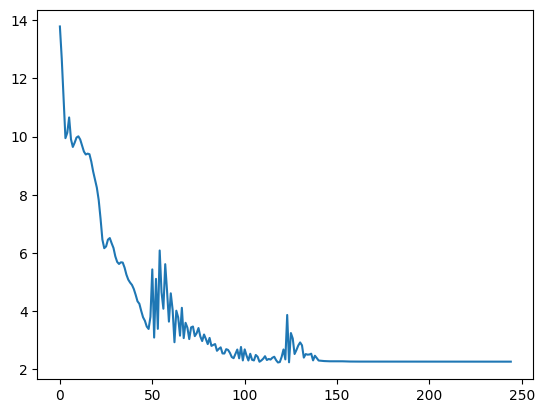

In [110]:
plt.plot(loss_list)
plt.show()

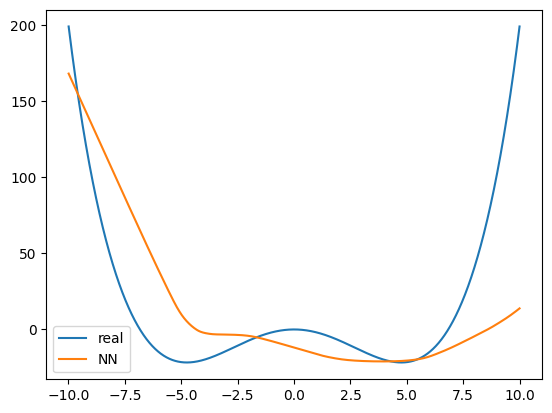

In [111]:

La=-10
Lb =10
L=Lb-La  # domain length
N = 3000 # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

V_NN=model(grid)

os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid.cpu().detach().numpy(),k)
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [ ]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 29.033865
max_error: 185.35043


: 